In [1]:
import numpy as np
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import json
import pickle
from sklearn.externals import joblib

In [2]:
import sys
sys.path.append('../src/')

In [3]:
from TFExpMachine import TFExpMachine, simple_batcher

# Load data (see movielens-prepare.ipynb)

In [4]:
X_tr, y_tr, s_features = joblib.load('tmp/train_categotical.jl')
X_te, y_te, s_features = joblib.load('tmp/test_categorical.jl')

# Prepare init from LogReg

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [6]:
target_rank = 10

oh = OneHotEncoder()
oh.fit(np.vstack((X_tr, X_te))-1)
X_tr_sp = oh.transform(X_tr-1)
X_te_sp = oh.transform(X_te-1)
logreg = LogisticRegression()
logreg.fit(X_tr_sp, y_tr)
y_pred = logreg.predict_proba(X_te_sp)[:, 1]
print(roc_auc_score(y_te, y_pred))

0.782123491491


In [7]:
target_rank = 10

num_features = len(s_features)
w_cores = [None] * num_features

coef = logreg.coef_[0]
intercept = logreg.intercept_[0]

# see paper for details about initialization
begin_feature = [0] + list(np.cumsum(s_features))
for i in range(num_features):
    n_factors = s_features[i]
    if i == 0:
        tmp = np.zeros((n_factors+1, 1, target_rank))
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:1,:2] = [1, 0]
            else:
                tmp[local_j,:1,:2] = [0, coef[global_j]]
        w_cores[i] = tmp.astype(np.float32)
            
    elif i == num_features-1:
        tmp = np.zeros((n_factors+1, target_rank, 1))
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:2,:1] = np.array([[intercept], [1]])
            else:
                tmp[local_j,:2,:1] = [[coef[global_j]], [0]]
        w_cores[i] = tmp.astype(np.float32)
            
    else:
        tmp = np.zeros((n_factors+1, target_rank, target_rank))
        for local_j, global_j in enumerate([-1] + list(range(begin_feature[i], s_features[i]))):
            if local_j==0:
                tmp[local_j,:2,:2] = np.eye(2)
            else:
                tmp[local_j,:2,:2] = [[0, coef[global_j]], [0,0]]
        w_cores[i] = tmp.astype(np.float32)

# Init model

In [13]:
model.destroy()
model = TFExpMachine(rank=target_rank, s_features=s_features, init_std=0.001, reg=0.012, exp_reg=1.8)
model.init_from_cores(w_cores)
model.build_graph()
model.initialize_session()

# Learning

In [14]:
epoch_hist = []
for epoch in range(50):
    # train phase
    loss_hist = []
    penalty_hist = []
    for x, y in simple_batcher(X_tr, y_tr, 256):
        fd = {model.X: x, model.Y: 2*y-1}
        run_ops = [model.trainer, model.outputs, model.loss, model.penalty]
        _, outs, batch_loss, penalty = model.session.run(run_ops, fd)
        loss_hist.append(batch_loss)
        penalty_hist.append(penalty)
    epoch_train_loss = np.mean(loss_hist)
    epoch_train_pen = np.mean(penalty_hist)
    
    epoch_stats = {
        'epoch': epoch,
        'train_logloss': float(epoch_train_loss)
    }
    
    # test phase
    if epoch%2==0 and epoch>0:
        fd = {model.X: X_te, model.Y: 2*y_te-1}
        run_ops = [model.outputs, model.loss, model.penalty, model.penalized_loss]
        outs, raw_loss, raw_penalty, loss = model.session.run(run_ops, fd)
        epoch_test_loss = roc_auc_score(y_te, outs)
        epoch_stats['test_auc'] = float(epoch_test_loss),
        epoch_stats['penalty'] = float(raw_penalty)
        print('{}: te_auc: {:.4f}'.format(epoch, epoch_test_loss))
    epoch_hist.append(epoch_stats)
    # dump to json
    json.dump(epoch_hist, open('./tmp/ExM_rank10_ereg1.8.json', 'w'))

2: te_auc: 0.7661
4: te_auc: 0.7713
6: te_auc: 0.7758
8: te_auc: 0.7780
10: te_auc: 0.7788
12: te_auc: 0.7794
14: te_auc: 0.7800
16: te_auc: 0.7806
18: te_auc: 0.7809
20: te_auc: 0.7811
22: te_auc: 0.7812
24: te_auc: 0.7814
26: te_auc: 0.7816
28: te_auc: 0.7818
30: te_auc: 0.7819
32: te_auc: 0.7822
34: te_auc: 0.7825
36: te_auc: 0.7828
38: te_auc: 0.7832
40: te_auc: 0.7834
42: te_auc: 0.7835
44: te_auc: 0.7835
46: te_auc: 0.7834
48: te_auc: 0.7834


In [ ]:
# Draw plot

Populating the interactive namespace from numpy and matplotlib


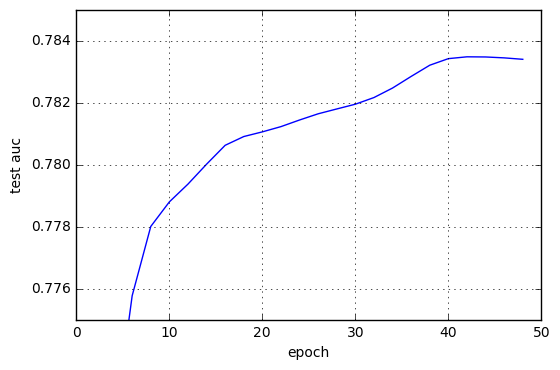

In [21]:
%pylab inline
plot([x['epoch'] for x in epoch_hist if 'test_auc' in x], [x['test_auc'] for x in epoch_hist if 'test_auc' in x])
grid()
ylim(0.775, 0.785)
xlabel('epoch')
ylabel('test auc')

In [22]:
# release resources
model.destroy()